In [1]:
import kagglehub
import os

# Download job descriptions dataset
print("Downloading job description dataset...")
dataset_path = kagglehub.dataset_download("ravindrasinghrana/job-description-dataset")
print("Job Description Dataset downloaded to:", dataset_path)
print("Files:", os.listdir(dataset_path))

# Download resume dataset
print("Downloading resume dataset...")
resume_dataset_path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")
print("Resume Dataset downloaded to:", resume_dataset_path)
print("Files:", os.listdir(resume_dataset_path))

# Paths to CSV files
jobs_csv_path = os.path.join(dataset_path, "job_descriptions.csv")


c:\Users\abamr\Desktop\ELovoTasks\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Job Description Dataset downloaded to: C:\Users\abamr\.cache\kagglehub\datasets\ravindrasinghrana\job-description-dataset\versions\1
Files: ['data', 'job_descriptions.csv']
Resume Dataset downloaded to: C:\Users\abamr\.cache\kagglehub\datasets\snehaanbhawal\resume-dataset\versions\1
Files: ['data', 'Resume']


In [2]:
resumes_csv_path = os.path.join(resume_dataset_path, "Resume/Resume.csv")


In [3]:
import pandas as pd

# Load datasets
jobs_df = pd.read_csv(jobs_csv_path)
resumes_df = pd.read_csv(resumes_csv_path)

# Inspect structure
print("Jobs dataset shape:", jobs_df.shape)
print("Resumes dataset shape:", resumes_df.shape)




Jobs dataset shape: (1615940, 23)
Resumes dataset shape: (2484, 4)


In [4]:
jobs_df.head().style.set_table_attributes("style='display:inline'").set_caption("Sample Job Descriptions")


,Job Id,Experience,Qualifications,Salary Range,location,Country,latitude,longitude,Work Type,Company Size,Job Posting Date,Preference,Contact Person,Contact,Job Title,Role,Job Portal,Job Description,Benefits,skills,Responsibilities,Company,Company Profile
0,1089843540111562,5 to 15 Years,M.Tech,$59K-$99K,Douglas,Isle of Man,54.236100,-4.548100,Intern,26801,2022-04-24,Female,Brandon Cunningham,001-381-930-7517x737,Digital Marketing Specialist,Social Media Manager,Snagajob,"Social Media Managers oversee an organizations social media presence. They create and schedule content, engage with followers, and analyze social media metrics to drive brand awareness and engagement.","{'Flexible Spending Accounts (FSAs), Relocation Assistance, Legal Assistance, Employee Recognition Programs, Financial Counseling'}","Social media platforms (e.g., Facebook, Twitter, Instagram) Content creation and scheduling Social media analytics and insights Community engagement Paid social advertising","Manage and grow social media accounts, create engaging content, and interact with the online community. Develop social media content calendars and strategies. Monitor social media trends and engagement metrics.",Icahn Enterprises,"{""Sector"":""Diversified"",""Industry"":""Diversified Financials"",""City"":""Sunny Isles Beach"",""State"":""Florida"",""Zip"":""33160"",""Website"":""www.ielp.com"",""Ticker"":""IEP"",""CEO"":""David Willetts""}"
1,398454096642776,2 to 12 Years,BCA,$56K-$116K,Ashgabat,Turkmenistan,38.969700,59.556300,Intern,100340,2022-12-19,Female,Francisco Larsen,461-509-4216,Web Developer,Frontend Web Developer,Idealist,"Frontend Web Developers design and implement user interfaces for websites, ensuring they are visually appealing and user-friendly. They collaborate with designers and backend developers to create seamless web experiences for users.","{'Health Insurance, Retirement Plans, Paid Time Off (PTO), Flexible Work Arrangements, Employee Assistance Programs (EAP)'}","HTML, CSS, JavaScript Frontend frameworks (e.g., React, Angular) User experience (UX)","Design and code user interfaces for websites, ensuring a seamless and visually appealing user experience. Collaborate with UX designers to optimize user journeys. Ensure cross-browser compatibility and responsive design.",PNC Financial Services Group,"{""Sector"":""Financial Services"",""Industry"":""Commercial Banks"",""City"":""Pittsburgh"",""State"":""Pennsylvania"",""Zip"":""15222"",""Website"":""www.pnc.com"",""Ticker"":""PNC"",""CEO"":""William S. Demchak""}"
2,481640072963533,0 to 12 Years,PhD,$61K-$104K,Macao,"Macao SAR, China",22.198700,113.543900,Temporary,84525,2022-09-14,Male,Gary Gibson,9687619505,Operations Manager,Quality Control Manager,Jobs2Careers,"Quality Control Managers establish and enforce quality standards within an organization. They develop quality control processes, perform inspections, and implement corrective actions to maintain product or service quality.","{'Legal Assistance, Bonuses and Incentive Programs, Wellness Programs, Employee Discounts, Retirement Plans'}","Quality control processes and methodologies Statistical process control (SPC) Root cause analysis and corrective action Quality management systems (e.g., ISO 9001) Compliance and regulatory knowledge",Establish and enforce quality control standards and procedures. Conduct quality audits and inspections. Collaborate with production teams to address quality issues and implement improvements.,United Services Automobile Assn.,"{""Sector"":""Insurance"",""Industry"":""Insurance: Property and Casualty (Stock)"",""City"":""San Antonio"",""State"":""Texas"",""Zip"":""78288"",""Website"":""www.usaa.com"",""Ticker"":"""",""CEO"":""Wayne Peacock""}"
3,688192671473044,4 to 11 Years,PhD,$65K-$91K,Porto-Novo,Benin,9.307700,2.315800,Full-Time,129896,2023-02-25,Female,Joy Lucero,+1-820-643-5431x47576,Network Engineer,Wireless Network Engineer,FlexJobs,"Wireless Network Engineers design, implement, and maintai

In [5]:
# Select columns that matter
important_cols = ['Job Title', 'Role', 'Job Description', 'skills', 'Responsibilities', 'Qualifications']

# Fill NaN with empty strings and combine
jobs_df['combined_text'] = jobs_df[important_cols].fillna('').agg(' '.join, axis=1)

# Check result
print(jobs_df[['Job Title', 'combined_text']].head(3))


                      Job Title  \
0  Digital Marketing Specialist   
1                 Web Developer   
2            Operations Manager   

                                       combined_text  
0  Digital Marketing Specialist Social Media Mana...  
1  Web Developer Frontend Web Developer Frontend ...  
2  Operations Manager Quality Control Manager Qua...  


In [6]:
print(resumes_df.head())

         ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR  


In [7]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = str(text).lower()  # lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # remove special characters
    words = [w for w in text.split() if w not in stop_words]  # remove stopwords
    return ' '.join(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abamr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Load a lightweight Sentence-BERT model
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

In [12]:
selected_job_text = jobs_df.iloc[66]['combined_text']  # change index if needed
print("Selected Job:\n", selected_job_text[:500], "\n")  # preview first 500 chars

# Encode job description
job_embedding = model.encode(preprocess_text(selected_job_text), convert_to_tensor=True)

Selected Job:
 Procurement Manager Procurement Analyst Analyze procurement data, identify cost-saving opportunities, and support the procurement process. Procurement processes Vendor assessment Contract negotiation Purchase order management Spend analysis Market research Supplier relationship management Data analysis Problem-solving Attention to detail Communication skills Financial acumen Analyze procurement data and trends to support decision-making. Conduct supplier evaluations and performance assessments.  



In [13]:
def normalize_score(score, min_val=0.2, max_val=0.8):
    normalized = (score - min_val) / (max_val - min_val)
    normalized = max(0, min(1, normalized))  # Clamp between 0 and 1
    return round(normalized * 100, 2)  # Convert to

In [15]:
# Take first 10 resumes for testing
resume_texts = resumes_df['Resume_str'].head(10)
resume_scores = []

from sentence_transformers import util

for i, resume in enumerate(resume_texts):
    resume_clean = preprocess_text(resume)
    resume_embedding = model.encode(resume_clean, convert_to_tensor=True)
    score = util.cos_sim(job_embedding, resume_embedding).item()
    resume_scores.append((i, score, resume[:300]))  # store index, score, snippet

# Sort by score descending
resume_scores.sort(key=lambda x: x[1], reverse=True)

# Display top matches
print("\nTop 5 matching resumes:")
for idx, score, snippet in resume_scores[:5]:
    print(f"\nRank {idx+1}: Score={normalize_score(score)}%")
    print(f"Snippet: {snippet}\n")


Top 5 matching resumes:

Rank 8: Score=41.96%
Snippet:          HR MANAGER         Professional Summary    Senior HR professional with a continuous improvement approach to building and supporting organizations.  Driven HR Manager bringing an innovative approach to human resource management while creating a team-driven environment that fosters room for d


Rank 9: Score=40.73%
Snippet:          HR SPECIALIST       Summary    Possess 15+ years of experience as an HR Classification/Compensation Lead and as an HR Specialist, Recruitment. Managed recruitment efforts that included qualifying candidates based on documented knowledge, skills, and abilities to match organizational resourc


Rank 4: Score=36.57%
Snippet:          HR SPECIALIST       Summary    Dedicated, Driven, and Dynamic with over 20 years of customer service expertise. Motivated to maintain customer satisfaction and contribute to company success with an emphasis in personnel and process management. Solid team player with pr

In [16]:
def extract_keywords(text1, text2):
    words1 = set(text1.split())
    words2 = set(text2.split())
    return list(words1.intersection(words2))

print("\nJustifications for top resumes:")
for idx, score, snippet in resume_scores[:3]:
    resume_clean = preprocess_text(resumes_df.iloc[idx]['Resume_str'])
    keywords = extract_keywords(preprocess_text(selected_job_text), resume_clean)
    print(f"\nResume Rank {idx+1}: Score={round(score*100, 2)}%")
    print(f"Matched Keywords: {keywords}")



Justifications for top resumes:

Resume Rank 8: Score=45.18%
Matched Keywords: ['data', 'mba', 'performance', 'vendor', 'processes', 'management', 'manager', 'market', 'process', 'analysis', 'skills', 'evaluations', 'communication']

Resume Rank 9: Score=44.44%
Matched Keywords: ['performance', 'research', 'negotiation', 'processes', 'management', 'analyst', 'manager', 'market', 'process', 'analysis', 'skills', 'conduct', 'evaluations', 'communication']

Resume Rank 4: Score=41.94%
Matched Keywords: ['management', 'skills', 'process', 'communication']


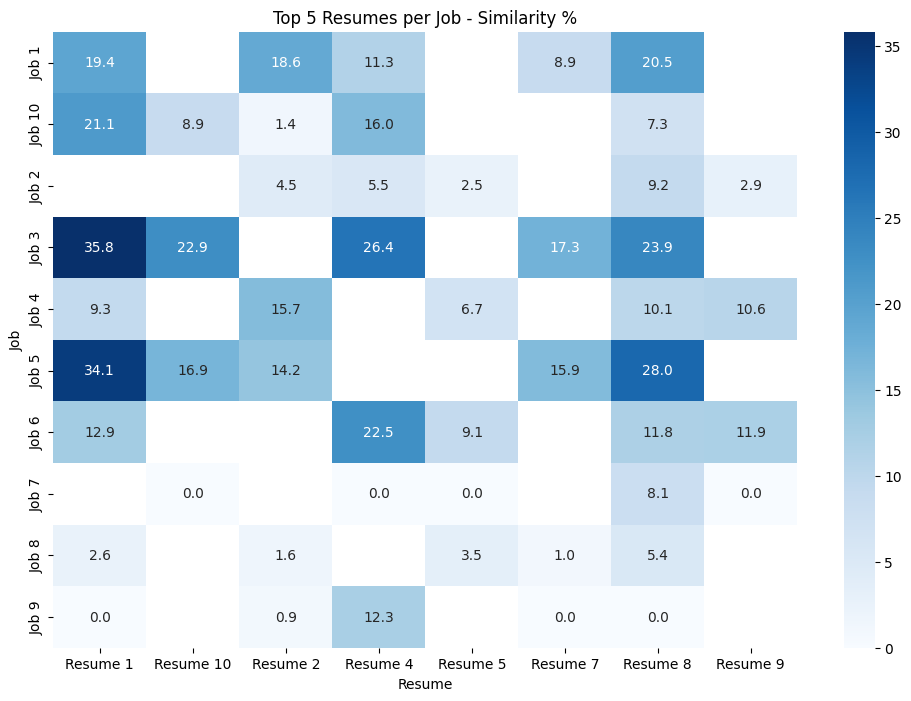

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util

job_texts = jobs_df['combined_text'].head(10).tolist()
resumes = resumes_df['Resume_str']


results = []

for job_idx, job in enumerate(job_texts):
    job_embedding = model.encode(job, convert_to_tensor=True)
    scores = []

    for resume_idx, resume in enumerate(resume_texts):
        resume_embedding = model.encode(resume, convert_to_tensor=True)
        score = util.cos_sim(job_embedding, resume_embedding).item()
        scores.append((resume_idx, score))

    # Sort and take top N
    top_resumes = sorted(scores, key=lambda x: x[1], reverse=True)[:5]

    for rank, (resume_idx, score) in enumerate(top_resumes, 1):
        results.append({
            "Job": f"Job {job_idx+1}",
            "Resume": f"Resume {resume_idx+1}",
            "Similarity": normalize_score(score)
        })

# Convert to DataFrame
df = pd.DataFrame(results)

# Visualization: Heatmap
pivot_df = df.pivot(index="Job", columns="Resume", values="Similarity")

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".1f")
plt.title("Top 5 Resumes per Job - Similarity %")
plt.xlabel("Resume")
plt.ylabel("Job")
plt.show()